# FlightDelay. 
# Проект__4_DA

Данные - https://www.kaggle.com/usdot/flight-delays

Описание - Сводная информация о количестве своевременных, задержанных, отмененных и измененных рейсов в США за 2015 год (5.8 млн записей)


Задачи:
1. Найти аэропорт с минимальной задержкой вылета 
2. Самая пунктуальная авиакомпания на прилет в Los Angeles International Airport (Международный аэропорт Лос-Анджелеса)
3. Аэропорт с самой большой долей руления на 1 самолетовылет
4. Построить модель которая будет выбирать топ 3 аэропорта прилета (вероятность опоздания минимальная – RMSE метрика),  в зависимости от аэропорта вылета  


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd drive/My\ Drive/Colab\ Notebooks

/content/drive/My Drive/Colab Notebooks


In [3]:
import pandas as pd
import datetime
import numpy as np
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.linear_model import LinearRegression
from google.colab import files

- Загрузим данные с Kaggle.

- Три таблицы со сводной информацией о количестве своевременных, задержанных, отмененных и измененных рейсов в США за 2015 год.

In [4]:
airlines = pd.read_csv('/content/drive/MyDrive/airlines.csv')
airports = pd.read_csv('/content/drive/MyDrive/airports.csv')
flights = pd.read_csv('/content/drive/MyDrive/flights.csv', dtype={'ORIGIN_AIRPORT':str, 'DESTINATION_AIRPORT':str})

- Проведем исследования данных, для дальнейшей работы

In [5]:
airlines.head()

,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways


In [6]:
airlines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   IATA_CODE  14 non-null     object
 1   AIRLINE    14 non-null     object
dtypes: object(2)
memory usage: 352.0+ bytes


- из информации о таблицы airlines видно, что нулевых значений нет (пропуски отсутствуют)

In [7]:
airports.head()

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447


In [8]:
airports.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322 entries, 0 to 321
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   IATA_CODE  322 non-null    object 
 1   AIRPORT    322 non-null    object 
 2   CITY       322 non-null    object 
 3   STATE      322 non-null    object 
 4   COUNTRY    322 non-null    object 
 5   LATITUDE   319 non-null    float64
 6   LONGITUDE  319 non-null    float64
dtypes: float64(2), object(5)
memory usage: 17.7+ KB


- из информации о таблицы airports видно, что в последних двух колонках (широта и долгота аэропорта) есть нулевые значения, но мы их использовать не будем, так что и пропуски удалять тоже не будем

In [9]:
flights.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,2354.0,-11.0,21.0,15.0,205.0,194.0,169.0,1448,404.0,4.0,430,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,2.0,-8.0,12.0,14.0,280.0,279.0,263.0,2330,737.0,4.0,750,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,18.0,-2.0,16.0,34.0,286.0,293.0,266.0,2296,800.0,11.0,806,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,15.0,-5.0,15.0,30.0,285.0,281.0,258.0,2342,748.0,8.0,805,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,24.0,-1.0,11.0,35.0,235.0,215.0,199.0,1448,254.0,5.0,320,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5819079 entries, 0 to 5819078
Data columns (total 31 columns):
 #   Column               Dtype  
---  ------               -----  
 0   YEAR                 int64  
 1   MONTH                int64  
 2   DAY                  int64  
 3   DAY_OF_WEEK          int64  
 4   AIRLINE              object 
 5   FLIGHT_NUMBER        int64  
 6   TAIL_NUMBER          object 
 7   ORIGIN_AIRPORT       object 
 8   DESTINATION_AIRPORT  object 
 9   SCHEDULED_DEPARTURE  int64  
 10  DEPARTURE_TIME       float64
 11  DEPARTURE_DELAY      float64
 12  TAXI_OUT             float64
 13  WHEELS_OFF           float64
 14  SCHEDULED_TIME       float64
 15  ELAPSED_TIME         float64
 16  AIR_TIME             float64
 17  DISTANCE             int64  
 18  WHEELS_ON            float64
 19  TAXI_IN              float64
 20  SCHEDULED_ARRIVAL    int64  
 21  ARRIVAL_TIME         float64
 22  ARRIVAL_DELAY        float64
 23  DIVERTED             int64  
 24

- посмотрим процент нулевых значений (пропусков) в таблице flights, так как по запросу 'info()', информации по пропускам отсутствует 

In [11]:
flights_null = flights.isnull().sum()*100/flights.shape[0]
flights_null

YEAR                    0.000000
MONTH                   0.000000
DAY                     0.000000
DAY_OF_WEEK             0.000000
AIRLINE                 0.000000
FLIGHT_NUMBER           0.000000
TAIL_NUMBER             0.252978
ORIGIN_AIRPORT          0.000000
DESTINATION_AIRPORT     0.000000
SCHEDULED_DEPARTURE     0.000000
DEPARTURE_TIME          1.480526
DEPARTURE_DELAY         1.480526
TAXI_OUT                1.530259
WHEELS_OFF              1.530259
SCHEDULED_TIME          0.000103
ELAPSED_TIME            1.805629
AIR_TIME                1.805629
DISTANCE                0.000000
WHEELS_ON               1.589822
TAXI_IN                 1.589822
SCHEDULED_ARRIVAL       0.000000
ARRIVAL_TIME            1.589822
ARRIVAL_DELAY           1.805629
DIVERTED                0.000000
CANCELLED               0.000000
CANCELLATION_REASON    98.455357
AIR_SYSTEM_DELAY       81.724960
SECURITY_DELAY         81.724960
AIRLINE_DELAY          81.724960
LATE_AIRCRAFT_DELAY    81.724960
WEATHER_DE

- Будем убирать нулевые значения, при необходимости (если будем использовать их в задачах)

# 1. Найти аэропорт с минимальной задержкой вылета

**- Посмотрим уникальные значения по cтобцам: ORIGIN_AIRPORT и DISTINATION_AIRPORT, чтобы стравнить с набором данных по IATA_CODE (идентификатор аэропорта) из таблицы airports**

In [12]:
flights.ORIGIN_AIRPORT.nunique()

628

In [13]:
flights.DESTINATION_AIRPORT.nunique()

629

In [14]:
flights_drop = flights.merge(airports[['IATA_CODE']],how='inner', left_on='ORIGIN_AIRPORT', right_on='IATA_CODE').drop('IATA_CODE',axis=1)
flights_drop = flights.merge(airports[['IATA_CODE']],how='inner', left_on='DESTINATION_AIRPORT', right_on='IATA_CODE').drop('IATA_CODE',axis=1)

In [15]:
flights_drop.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,2354.0,-11.0,21.0,15.0,205.0,194.0,169.0,1448,404.0,4.0,430,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AS,108,N309AS,ANC,SEA,45,41.0,-4.0,17.0,58.0,204.0,194.0,173.0,1448,451.0,4.0,509,455.0,-14.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,DL,1560,N3743H,ANC,SEA,45,31.0,-14.0,25.0,56.0,210.0,200.0,171.0,1448,447.0,4.0,515,451.0,-24.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AS,130,N457AS,FAI,SEA,115,107.0,-8.0,25.0,132.0,213.0,218.0,186.0,1533,538.0,7.0,548,545.0,-3.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,136,N431AS,ANC,SEA,135,NaN,NaN,NaN,NaN,205.0,NaN,NaN,1448,NaN,NaN,600,NaN,NaN,0,1,A,NaN,NaN,NaN,NaN,NaN


**- Видно что данные из таблицы airports, по колонке AIRPORT составляют 322 уникальных значени, а в таблице flights по колонкам ORIGIN_AIRPORT и DESTINATION_AIRPORT их больше, что говорит о наличии аэропортов, которых нет в исходной таблице aitports.**

- Давайте уберем ненужные записи из таблицы flights и сразу уберем пропуски (нулевые значения) т.е. объеденим данных из двух таблиц

In [16]:
flights_drop.ORIGIN_AIRPORT.nunique()

322

In [17]:
flights_drop.DESTINATION_AIRPORT.nunique()

322

**- Получаем одинаковое значение по колонкам, без пропусков**

- Из полученного DataFrame, проводим группировку по аэропортам вылета (ORIGIN_AIRPORT) и среднему значению полной зарержки при отправлении (DEPARTURE_DELAY), при этом убираем отмененные рейсы (CANCELLED=1), так как у нас задача: 'найти аэропорты с минимальной задержкой вылета'
- Из полученного набора данных, проводим сортировку по колонке  DEPARTURE_DELAY и собираем данные по двум значениям: ORIGIN_AIRPORT (стартовый аэропорт) и DEPARTURE_DELAY (полная задержка при отправки) по возрастанию 

In [18]:
flights_sort = flights_drop[flights_drop.CANCELLED==0].groupby('ORIGIN_AIRPORT')['DEPARTURE_DELAY'].mean().reset_index().sort_values(by='DEPARTURE_DELAY')
flights_sort

,ORIGIN_AIRPORT,DEPARTURE_DELAY
320,YAK,-6.292237
70,CNY,-6.058537
98,EKO,-3.771760
314,VEL,-3.740000
56,CDV,-3.261868
...,...,...
231,OTH,17.777358
293,STC,18.692308
147,HYA,23.182927
219,MVY,25.907317


- Далее таблицу flights_sort объединяем с таблицей airports, чтобы получить данные по найденному аэропорту с минимальной задержкой вылета

In [19]:
flights_sort.merge(airports, left_on='ORIGIN_AIRPORT', right_on='IATA_CODE', how = 'inner').head(1)

,ORIGIN_AIRPORT,DEPARTURE_DELAY,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,YAK,-6.292237,YAK,Yakutat Airport,Yakutat,AK,USA,59.50336,-139.66023


- нарисуем график адержек по аэропорту *Yakutat Airport*, который является аэропортов с минимальной зарержкой вылета

In [20]:
import seaborn as sns, numpy as np
import matplotlib.pyplot as plt

<Figure size 1440x504 with 0 Axes>

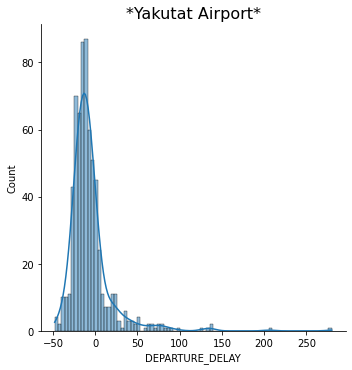

In [21]:
plt.figure(figsize=(20, 7))
sns.displot(flights_drop[flights_drop.ORIGIN_AIRPORT=='YAK']['DEPARTURE_DELAY'], kde=True)
plt.title('*Yakutat Airport*', fontsize=16);

# 2. Самая пунктуальная авиакомпания на прилет в Los Angeles International Airport


- в колонке 'ARRIVAL_DELAY' (задержка прибытия), есть пропуски 1,8%, давайте их удалим, чтобы дальше работать с данными 

In [22]:
flights_drop = flights.dropna(subset=['ARRIVAL_DELAY'])
flights_drop.isnull().sum()*100/flights_drop.shape[0]

YEAR                     0.000000
MONTH                    0.000000
DAY                      0.000000
DAY_OF_WEEK              0.000000
AIRLINE                  0.000000
FLIGHT_NUMBER            0.000000
TAIL_NUMBER              0.000000
ORIGIN_AIRPORT           0.000000
DESTINATION_AIRPORT      0.000000
SCHEDULED_DEPARTURE      0.000000
DEPARTURE_TIME           0.000000
DEPARTURE_DELAY          0.000000
TAXI_OUT                 0.000000
WHEELS_OFF               0.000000
SCHEDULED_TIME           0.000000
ELAPSED_TIME             0.000000
AIR_TIME                 0.000000
DISTANCE                 0.000000
WHEELS_ON                0.000000
TAXI_IN                  0.000000
SCHEDULED_ARRIVAL        0.000000
ARRIVAL_TIME             0.000000
ARRIVAL_DELAY            0.000000
DIVERTED                 0.000000
CANCELLED                0.000000
CANCELLATION_REASON    100.000000
AIR_SYSTEM_DELAY        81.388913
SECURITY_DELAY          81.388913
AIRLINE_DELAY           81.388913
LATE_AIRCRAFT_

- далее проведем группировку по аэпропорту 'LAX' (Los Angeles), как указвно в задачи и среднему значению задержки прибытия


In [23]:
flights_arrival = flights_drop[flights_drop.DESTINATION_AIRPORT=='LAX'].groupby('AIRLINE')['ARRIVAL_DELAY'].mean().reset_index()
flights_arrival

,AIRLINE,ARRIVAL_DELAY
0,AA,2.691133
1,AS,0.536180
2,B6,0.155539
3,DL,2.135468
4,F9,11.630624
5,HA,-4.668819
6,MQ,18.302469
7,NK,18.502564
8,OO,8.645215
9,UA,8.551574


- из полученного DataFrame, проведем сотртировку по задержке прибытия по возрастанию 

In [24]:
flights_airline = flights_arrival.sort_values(by='ARRIVAL_DELAY')
flights_airline

,AIRLINE,ARRIVAL_DELAY
5,HA,-4.668819
2,B6,0.155539
1,AS,0.536180
3,DL,2.135468
0,AA,2.691133
10,US,3.039387
11,VX,4.424613
9,UA,8.551574
8,OO,8.645215
12,WN,9.008806


- и по полученным данным, находим самую пунтктуальную авиакомпанию на прилете в Los Angeles International Airport

In [25]:
flights_airline.merge(airlines, left_on='AIRLINE', right_on='IATA_CODE', how = 'inner').head(1).drop('AIRLINE_x', axis=1)

,ARRIVAL_DELAY,IATA_CODE,AIRLINE_y
0,-4.668819,HA,Hawaiian Airlines Inc.


# 3. Аэропорт с самой большой долей руления на 1 самолетовылет


- Посмотрим пропуски по колонкам, с котрыми будем работать по данной задачи (данные выше): 'TAXI_OUT'(руление), 'ORIGIN_AIRPORT'(стартовый аэропорт), 'CANCELLED'(отмена рейса, 1=отмена)

- в колонке 'TAXI_OUT', есть пропуски, двайте их удалим

In [26]:
flights_drop = flights.dropna(subset=['TAXI_OUT'])
flights_drop.isnull().sum()*100/flights_drop.shape[0]

YEAR                    0.000000
MONTH                   0.000000
DAY                     0.000000
DAY_OF_WEEK             0.000000
AIRLINE                 0.000000
FLIGHT_NUMBER           0.000000
TAIL_NUMBER             0.000000
ORIGIN_AIRPORT          0.000000
DESTINATION_AIRPORT     0.000000
SCHEDULED_DEPARTURE     0.000000
DEPARTURE_TIME          0.000000
DEPARTURE_DELAY         0.000000
TAXI_OUT                0.000000
WHEELS_OFF              0.000000
SCHEDULED_TIME          0.000105
ELAPSED_TIME            0.279649
AIR_TIME                0.279649
DISTANCE                0.000000
WHEELS_ON               0.060488
TAXI_IN                 0.060488
SCHEDULED_ARRIVAL       0.000000
ARRIVAL_TIME            0.060488
ARRIVAL_DELAY           0.279649
DIVERTED                0.000000
CANCELLED               0.000000
CANCELLATION_REASON    99.985393
AIR_SYSTEM_DELAY       81.440959
SECURITY_DELAY         81.440959
AIRLINE_DELAY          81.440959
LATE_AIRCRAFT_DELAY    81.440959
WEATHER_DE

- создадим функцию, которая извлекает статистические параметры из объекта groupby по аэропортам ('ORIGIN_AIRPORT'), чтобы получит отношения суммы руления и количества вылетов, таким образом мы найдем мы найдем аэропорт с самой большой долей руления 

In [27]:
def deff(group):
    return {'deff': group.sum()/group.count()}
flights_deff = flights_drop[flights_drop.CANCELLED==0]['TAXI_OUT'].groupby(flights_drop['ORIGIN_AIRPORT']).apply(deff).unstack()
flights_deff = flights_deff.sort_values('deff', ascending=False)
flights_deff

,deff
ORIGIN_AIRPORT,
JFK,27.010175
LGA,26.721596
12953,26.660012
12478,23.677466
13502,23.666667
...,...
SCC,7.097969
10170,6.857143
BRW,6.798309


- соединяем данные из полученного DataFrame и таблицы 'airports', для вывода аэропорта с самой большой долей руления на 1 самолетовылет

In [28]:
flights_deff.merge(airports, left_on='ORIGIN_AIRPORT', right_on='IATA_CODE', how = 'inner').head(1)

,deff,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,27.010175,JFK,John F. Kennedy International Airport (New Yor...,New York,NY,USA,40.63975,-73.77893


# 4. Построить модель которая будет выбирать топ 3 аэропорта прилета (вероятность опоздания минимальная – RMSE метрика), в зависимости от аэропорта вылета

- Группируем flights_drop до дня

In [29]:
%%time
def make_date(df):
  return datetime.date(df.YEAR, df.MONTH, df.DAY)

def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.dDate.dt.year
    data['month'] = data.dDate.dt.month
    data['day'] = data.dDate.dt.day
    data['dayofweek'] = data.dDate.dt.dayofweek
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['ARRIVAL_DELAY'].shift(lag)

flights_drop['dDate'] = flights_drop.apply(make_date,axis = 1)

CPU times: user 2min 22s, sys: 2.39 s, total: 2min 25s
Wall time: 2min 25s


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


- Проводим группировку по датам, аэропортам прилета и задержке прибытия и преобразовываем даты(числа) в формат datetime, для генерачии фич, для временного ряда

In [ ]:
%%time
flight_grouped = flights_drop.groupby(['dDate','DESTINATION_AIRPORT'])['ARRIVAL_DELAY'].sum().reset_index()
flight_grouped['dDate'] = pd.to_datetime(flight_grouped['dDate'])

CPU times: user 858 ms, sys: 9.8 ms, total: 868 ms
Wall time: 867 ms


- делим flights на train/test

- генерируем фичи для временного ряда

- строим модель 'ARRIAL_DELAY'(задержка прибытия) для всех аэропортов 





In [ ]:
%%time
where_to_go = []
for dest in flight_grouped.DESTINATION_AIRPORT.unique():
    tempo = flight_grouped[flight_grouped.DESTINATION_AIRPORT==dest][['dDate','ARRIVAL_DELAY']]
    tempo.columns = ['dDate','ARRIVAL_DELAY']
    tempo = pd.DataFrame(tempo)
    
    try:
    
        make_features(tempo,21,7)
        tempo.dropna(inplace=True)
        tempo.set_index('dDate',inplace=True)
           
        X_train,X_test,y_train, y_test = train_test_split(tempo.drop('ARRIVAL_DELAY', axis=1),tempo.ARRIVAL_DELAY, shuffle=False, test_size=0.25)

        model_lr = LinearRegression()
        model_lr.fit(X_train,y_train)

        y_predicted_lr = model_lr.predict(X_test)
        where_to_go.append([dest,y_test.mean(),np.sqrt(mean_squared_error(y_test, y_predicted_lr))])

    except Exception as e:
        print('Error', str(e))

CPU times: user 9.58 s, sys: 54.4 ms, total: 9.64 s
Wall time: 9.59 s


- собираем DataFrame из данных: аэропорт прилета, среднего значения по задержке прибытия и параметра RMSE (среднеквадратичная ошибка), как указано в задачи (вероятность опоздания минимальная - RMSE метрика), которую мы посчитали выше

In [ ]:
%%time
where_to_go = pd.DataFrame(where_to_go)
where_to_go.columns = ['DESTINATION_AIRPORT','MEAN_ARRIVAL_DELAY_IN_PAST','RMSE']

CPU times: user 1.8 ms, sys: 0 ns, total: 1.8 ms
Wall time: 1.82 ms


In [ ]:
where_to_go.head()

,DESTINATION_AIRPORT,MEAN_ARRIVAL_DELAY_IN_PAST,RMSE
0,ABE,32.316456,96.974756
1,ABI,-5.683544,92.460573
2,ABQ,205.240506,410.706845
3,ABR,0.443038,44.048350
4,ABY,26.645570,64.908040


- случайным образом выбираем аэропорт вылета 

- используя данные моделей выбираем ТОП3 аэропорта с минимальной задержкой и RMSE

In [ ]:
%%time
start_airport = np.random.choice(flights_drop['ORIGIN_AIRPORT'].unique()) 
where_to_go_from_start_airport = flights_drop[flights_drop.ORIGIN_AIRPORT==start_airport]['DESTINATION_AIRPORT'].unique()

where_to_go_from_start_airport = pd.DataFrame(where_to_go_from_start_airport)
where_to_go_from_start_airport.columns = ['DESTINATION_AIRPORT']

top3 = where_to_go_from_start_airport\
    .merge(where_to_go,on='DESTINATION_AIRPORT',how='inner')\
    .sort_values(by=['RMSE','MEAN_ARRIVAL_DELAY_IN_PAST'],ascending=[True, True])\
    .head(3)

print('Лучшие направления с аэропорта',start_airport)
print('')
print(top3)

Лучшие направления с аэропорта LSE

  DESTINATION_AIRPORT  MEAN_ARRIVAL_DELAY_IN_PAST          RMSE
0                 MSP                  547.721519   2985.553102
1                 ORD                 1024.860759  15112.145888
CPU times: user 606 ms, sys: 1.84 ms, total: 608 ms
Wall time: 607 ms


- Данная модель построеная на методе линейной регрессии.
Она прогназурует среднее значение задержки прибытия в прошлом и качество модели по RMSE, в зависимсти от аэпопорта вылета, и паказавает три лучших аэропорта с минимальной вероятностью опоздания.